# 以MNIST資料集訓練VAE模型，並生成影像

In [3]:
# 載入相關套件
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from scipy.stats import norm

C:\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## 取得 MNIST 訓練資料

In [4]:
# 取得 MNIST 訓練資料
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape, x_te.shape)

(60000, 784) (10000, 784)


## 定義編碼器模型

In [5]:
# 超參數設定
batch_size, n_epoch = 100, 100  # 訓練執行批量、週期
n_hidden, z_dim = 256, 2        # 編碼器隱藏層神經元個數、輸出層神經元個數

In [6]:
# encoder
x = Input(shape=(x_tr.shape[1:]))
x_encoded = Dense(n_hidden, activation='relu')(x)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

# encoder 後接 Dense，估算平均數 mu
mu = Dense(z_dim)(x_encoded)

# encoder 後接 Dense，估算 log 變異數 log_var
log_var = Dense(z_dim)(x_encoded)

## 定義抽樣函數

In [7]:
# 定義抽樣函數
def sampling(args):
    # 根據 mu, log_var 取隨機亂數
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

# 定義匿名函數，進行抽樣
z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])

## 定義解碼器模型

In [8]:
# decoder
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

# 解碼的輸入為匿名函數
z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

## 定義特殊的損失函數(loss)

In [9]:
# 定義特殊的損失函數(loss)
reconstruction_loss = tf.keras.losses.binary_crossentropy(x, y) * x_tr.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

vae = Model(x, y)   # x:MNIST圖像， y:解碼器的輸出
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

# 顯示模型彙總資訊
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            258         dense_1[0][0]                    
______________________________________________________________________________________________

## 訓練模型

In [11]:
# 訓練模型
vae.fit(x_tr,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te, None), verbose=1)

Epoch 1/100
600/600 [==============================] - 6s 9ms/step - loss: 211.2926 - val_loss: 167.0967
Epoch 2/100
600/600 [==============================] - 5s 8ms/step - loss: 164.6353 - val_loss: 159.4981
Epoch 3/100
600/600 [==============================] - 5s 8ms/step - loss: 157.3502 - val_loss: 153.7775
Epoch 4/100
600/600 [==============================] - 5s 8ms/step - loss: 152.7555 - val_loss: 150.7299
Epoch 5/100
600/600 [==============================] - 5s 8ms/step - loss: 150.2683 - val_loss: 148.9137
Epoch 6/100
600/600 [==============================] - 5s 8ms/step - loss: 147.9561 - val_loss: 147.9106
Epoch 7/100
600/600 [==============================] - 5s 9ms/step - loss: 146.4720 - val_loss: 146.5514
Epoch 8/100
600/600 [==============================] - 5s 8ms/step - loss: 145.2411 - val_loss: 144.6325
Epoch 9/100
600/600 [==============================] - 5s 8ms/step - loss: 144.1023 - val_loss: 143.5429
Epoch 10/100
600/600 [==============================] -

600/600 [==============================] - 5s 8ms/step - loss: 133.5487 - val_loss: 136.5549
Epoch 79/100
600/600 [==============================] - 5s 8ms/step - loss: 133.5769 - val_loss: 136.2022
Epoch 80/100
600/600 [==============================] - 5s 8ms/step - loss: 133.2870 - val_loss: 136.9779
Epoch 81/100
600/600 [==============================] - 5s 8ms/step - loss: 133.2776 - val_loss: 136.3727
Epoch 82/100
600/600 [==============================] - 5s 8ms/step - loss: 133.3408 - val_loss: 137.2100
Epoch 83/100
600/600 [==============================] - 5s 8ms/step - loss: 132.9154 - val_loss: 137.1728
Epoch 84/100
600/600 [==============================] - 5s 9ms/step - loss: 133.1039 - val_loss: 136.4500
Epoch 85/100
600/600 [==============================] - 5s 9ms/step - loss: 133.0132 - val_loss: 136.4289
Epoch 86/100
600/600 [==============================] - 5s 8ms/step - loss: 133.1338 - val_loss: 136.3932
Epoch 87/100
600/600 [==============================] - 5s 

## 取得編碼器的輸出，以測試資料預測，以編碼器的輸出繪圖

In [12]:
# 取得編碼器的輸出 mu
encoder = Model(x, mu)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________


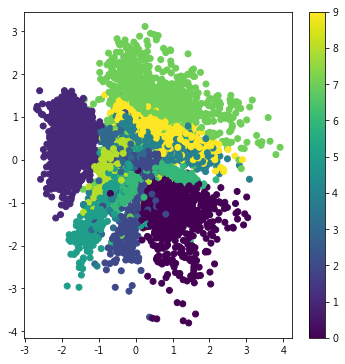

In [13]:
# 以測試資料預測，以編碼器的輸出繪圖
x_te_latent = encoder.predict(x_te, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te)
plt.colorbar()
plt.show()

## 取得解碼器的輸出，以測試資料預測，以解碼器的輸出圖像

In [14]:
# 取得解碼器的輸出
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              multiple                  384       
_________________________________________________________________
dense_5 (Dense)              multiple                  33024     
_________________________________________________________________
dense_6 (Dense)              multiple                  201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


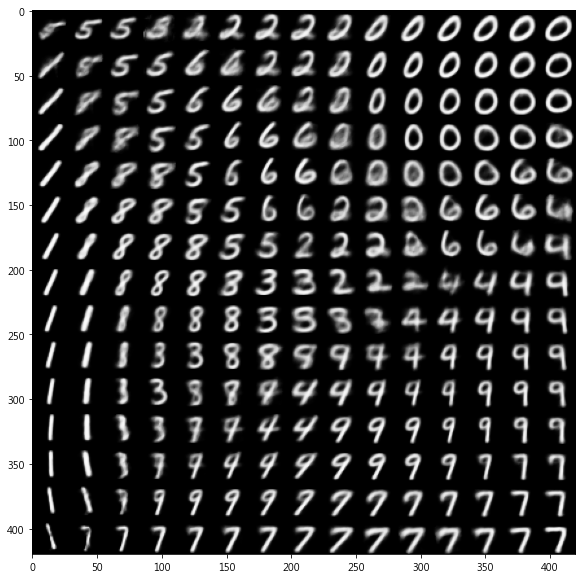

In [15]:
# 顯示 2D manifold 
n = 15           # 顯示 15x15 視窗
digit_size = 28  # 圖像尺寸
figure = np.zeros((digit_size * n, digit_size * n))

# 
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# 取得各種機率下的生成的樣本
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()